# Statistical Analysis of Binary Biometric Embeddings

In this notebook, we analyze the statistical properties of binary biometric embeddings extracted from face images. We explore the distribution of Hamming weights, compute Hamming distances between different users, and evaluate system performance by calculating the False Acceptance Rate (FAR) and False Rejection Rate (FRR). These analyses help in understanding the discriminative power and robustness of the biometric system.


In [5]:
import numpy as np
from scipy.stats import norm
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from err_calc_npy import load_float_embeddings, gen_pairs, cal_distances, evaluate_threshold, find_eer
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

In [6]:
def epsilon(k, n, t):
    """
    Calculate the epsilon value based on the given parameters.
    
    Parameters:
    k (int): Code dimension.
    n (int): Code length.
    t (float): number of corrected errors.
    
    Returns:
    float: The calculated epsilon value.
    """
    if k > n or k < 0 or n <= 0:
        raise ValueError("Invalid values for k and n.")
    
    # Calculate epsilon using the formula
    p = (t/n)
    ϵ = -1 + k/n - p*np.log2(p) - (1 - p)*np.log2(1 - p)
    return ϵ
def gauss(x,mu, sigma):
    """
    Gaussian function for plotting.
    
    Parameters:
    x (array): Input values.
    mu (float): Mean of the Gaussian.
    sigma (float): Standard deviation of the Gaussian.
    a (float): Amplitude of the Gaussian.
    
    Returns:
    array: Gaussian values for the input x.
    """
    return 1/np.sqrt(2*np.pi*sigma**2) * np.exp(-0.5*((x-mu)/sigma)**2)
def binary_to_gray(n):
    return n ^ (n >> 1)
    

## Fully Random Binarization

In [7]:
def binarize(data_f: dict, thresholds: list, binarization_type: str = 'binary'):
    """
    Binarize the float embeddings based on a threshold.
    
    Parameters:
    data_f (dict): Dictionary containing float embeddings.
    threshold (float): Threshold for binarization.
    
    Returns:
    dict: Dictionary with binarized embeddings.
    """
    thresholds = np.sort(np.array(thresholds))
    data_b = {}
    if binarization_type == 'binary':
        ## Express posoitions with log2(n+1) bits like 0000, 0001, 0010, 0011, 0100, 0101, ...
        bin_length = int(np.ceil(np.log2(len(thresholds) + 1)))
        for key, value in data_f.items():
            bin_indices = []
            for i in range(len(value)):
                interval_indices = np.searchsorted(thresholds, value[i], side='right')
                bin_index = np.concatenate([np.array(list(np.binary_repr(idx, width=bin_length)), dtype=int) for idx in interval_indices], axis =0 )
                bin_indices.append(bin_index.tolist())
            data_b[key] = np.stack(bin_indices, axis = 0)
    if binarization_type == 'gray':
        bin_length = int(np.ceil(np.log2(len(thresholds) + 1)))
        for key, value in data_f.items():
            bin_indices = []
            for i in range(len(value)):
                interval_indices = np.searchsorted(thresholds, value[i], side='right')
                bin_index = np.concatenate([
                    np.array(list(np.binary_repr(binary_to_gray(idx), width=bin_length)), dtype=int)
                    for idx in interval_indices
                ], axis=0)
                bin_indices.append(bin_index.tolist())
            data_b[key] = np.stack(bin_indices, axis = 0)
    if binarization_type == 'standard':
        bin_length = int((len(thresholds) + 1))
        ## n as 0000, 0001, 0011, 0111, 1111
        for key, value in data_f.items():
            bin_indices = []
            for i in range(len(value)):
                interval_indices = np.searchsorted(thresholds, value[i], side='right')
                bin_index = np.concatenate([np.array(list(np.binary_repr(2**idx-1, width=bin_length)), dtype=int) for idx in interval_indices], axis =0 )
                bin_indices.append(bin_index.tolist())
            data_b[key] = np.stack(bin_indices, axis = 0)
    return data_b

Load Dataset

In [8]:
model = 512
float_dim = model

dataset_dir = f"./embeddings{model}_float_LFW"
data_f512 = load_float_embeddings(dataset_dir, float_dim)


embeddings_512 = []
for _, mat in data_f512.items():
    embeddings_512.append(np.concatenate(mat, axis = 0))
embeddings_512 = np.concatenate(embeddings_512, axis = 0)

model = 128
float_dim = model

dataset_dir = f"./embeddings{model}_float_LFW"
data_f128 = load_float_embeddings(dataset_dir, float_dim)


embeddings_128 = []
for _, mat in data_f128.items():
    embeddings_128.append(np.concatenate(mat, axis = 0))
embeddings_128 = np.concatenate(embeddings_128, axis = 0)


Running binary binarization
People selected for genuine pairs: 1272


Generating impostor pairs: 100%|██████████| 100000/100000 [00:00<00:00, 111781.10it/s]


Running binary binarization
People selected for genuine pairs: 1272


Generating impostor pairs: 100%|██████████| 100000/100000 [00:00<00:00, 117758.19it/s]


Running binary binarization
People selected for genuine pairs: 1272


Generating impostor pairs: 100%|██████████| 100000/100000 [00:00<00:00, 154625.01it/s]


Running binary binarization
People selected for genuine pairs: 1272


Generating impostor pairs: 100%|██████████| 100000/100000 [00:00<00:00, 150969.06it/s]


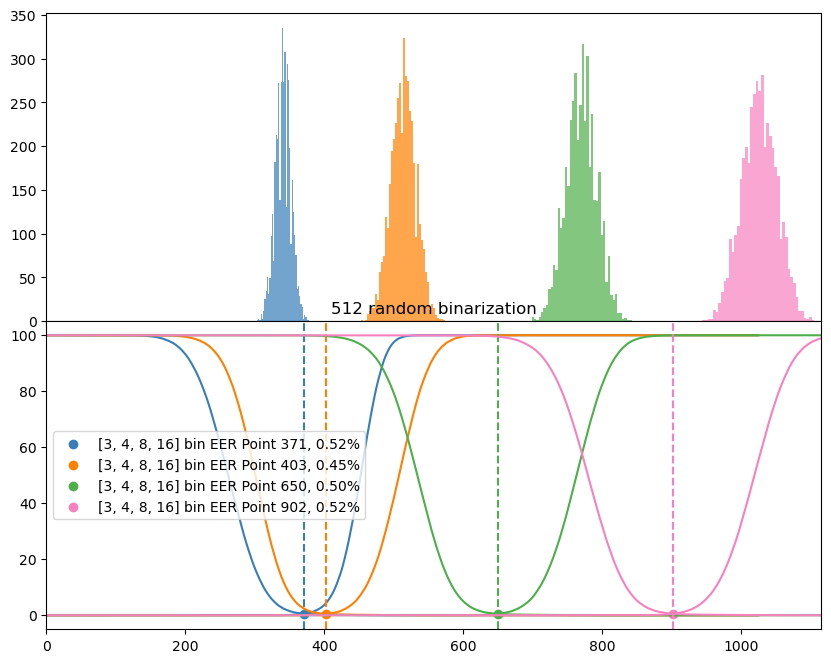

In [ ]:
# Initialize plot
fig = plt.figure(figsize=(10, 8))
gs = fig.add_gridspec(2, hspace=0)
axs = gs.subplots(sharex=True, sharey=False)

# Number of bins to binarize data. The equal probability intevals are latter calculated
bits_list = [3, 4, 8, 16]
for i, bits in enumerate(bits_list):
    # Load embeddings and binarize data
    thresholds = [norm.ppf(1-1/(bits)*i)*np.std(embeddings_512)+np.mean(embeddings_512) for i in range(1, bits)]
    data_b = binarize(data_f512, thresholds, "binary") # Takes 4 secs approx
    # Generate pair of geunine and impostor embeddings
    genuines, imposters = gen_pairs(data_b)
    dist_g = cal_distances(genuines)
    dist_i = cal_distances(imposters)


    bin_length = next(iter(data_b.values())).shape[1]
    thresholds = list(range(0, bin_length + 1))
    fars, frrs = evaluate_threshold(dist_g, dist_i, thresholds)
    eer_th, eer_val = find_eer(thresholds, fars, frrs)

    weights = [int(arr[0].sum()) for arr in data_b.values()]

    # Hamming weight histograms
    mu = np.mean(weights)
    sigma = np.std(weights)
    axs[0].hist(weights, bins=np.linspace(min(weights), max(weights), int(len(weights)/100)), alpha=0.7, color=CB_color_cycle[i])
    
    # FAR and FRR curves
    axs[1].plot(thresholds, fars, color=CB_color_cycle[i])
    axs[1].plot(thresholds, frrs, color=CB_color_cycle[i])
    axs[1].axvline(eer_th, color=CB_color_cycle[i], linestyle='--')
    axs[1].scatter([eer_th], [eer_val], color=CB_color_cycle[i], label=f'{bits_list} bin EER Point '+f"{eer_th}, {eer_val:.2f}%")

    axs[1].set_xlim(0, max(weights)+10)
axs[1].legend()
axs[0].title("512 random binarization")
plt.show()



People selected for genuine pairs: 1272


Generating impostor pairs: 100%|██████████| 100000/100000 [00:00<00:00, 150809.96it/s]


People selected for genuine pairs: 1272


Generating impostor pairs: 100%|██████████| 100000/100000 [00:00<00:00, 150918.43it/s]


People selected for genuine pairs: 1272


Generating impostor pairs: 100%|██████████| 100000/100000 [00:00<00:00, 150663.97it/s]


People selected for genuine pairs: 1272


Generating impostor pairs: 100%|██████████| 100000/100000 [00:00<00:00, 136102.96it/s]


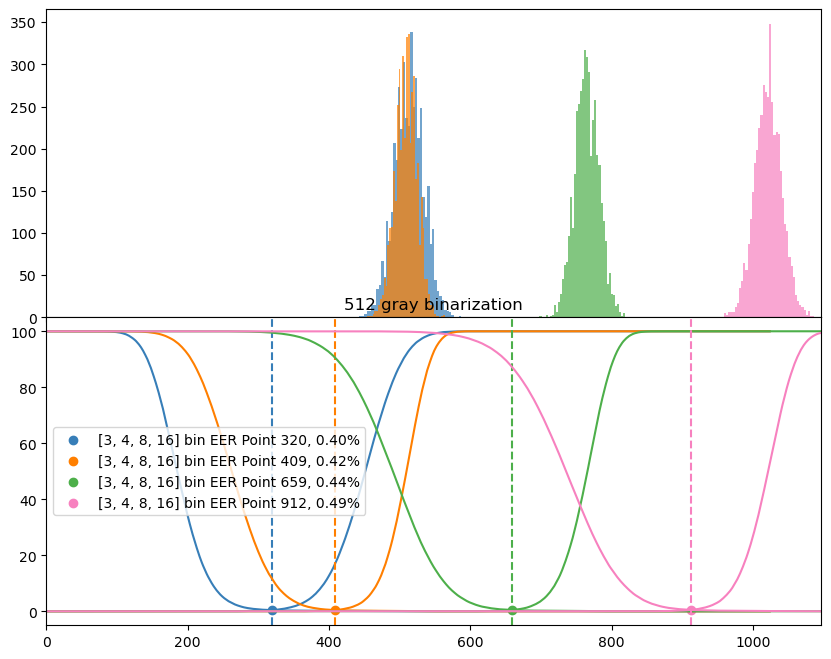

In [12]:
# Initialize plot
fig = plt.figure(figsize=(10, 8))
gs = fig.add_gridspec(2, hspace=0)
axs = gs.subplots(sharex=True, sharey=False)

# Number of bins to binarize data. The equal probability intevals are latter calculated
bits_list = [3, 4, 8, 16]
for i, bits in enumerate(bits_list):
    # Load embeddings and binarize data
    thresholds = [norm.ppf(1-1/(bits)*i)*np.std(embeddings_512)+np.mean(embeddings_512) for i in range(1, bits)]
    data_b = binarize(data_f512, thresholds, "gray") # Takes 4 secs approx
    # Generate pair of geunine and impostor embeddings
    genuines, imposters = gen_pairs(data_b)
    dist_g = cal_distances(genuines)
    dist_i = cal_distances(imposters)


    bin_length = next(iter(data_b.values())).shape[1]
    thresholds = list(range(0, bin_length + 1))
    fars, frrs = evaluate_threshold(dist_g, dist_i, thresholds)
    eer_th, eer_val = find_eer(thresholds, fars, frrs)

    weights = [int(arr[0].sum()) for arr in data_b.values()]

    # Hamming weight histograms
    mu = np.mean(weights)
    sigma = np.std(weights)
    axs[0].hist(weights, bins=np.linspace(min(weights), max(weights), int(len(weights)/100)), alpha=0.7, color=CB_color_cycle[i])
    
    # FAR and FRR curves
    axs[1].plot(thresholds, fars, color=CB_color_cycle[i])
    axs[1].plot(thresholds, frrs, color=CB_color_cycle[i])
    axs[1].axvline(eer_th, color=CB_color_cycle[i], linestyle='--')
    axs[1].scatter([eer_th], [eer_val], color=CB_color_cycle[i], label=f'{bits_list} bin EER Point '+f"{eer_th}, {eer_val:.2f}%")

    axs[1].set_xlim(0, max(weights)+10)
axs[1].legend()
axs[0].title("512 gray binarization")
plt.show()

People selected for genuine pairs: 1272


Generating impostor pairs: 100%|██████████| 100000/100000 [00:00<00:00, 143088.63it/s]


People selected for genuine pairs: 1272


Generating impostor pairs: 100%|██████████| 100000/100000 [00:00<00:00, 150640.10it/s]


People selected for genuine pairs: 1272


Generating impostor pairs: 100%|██████████| 100000/100000 [00:00<00:00, 144597.02it/s]


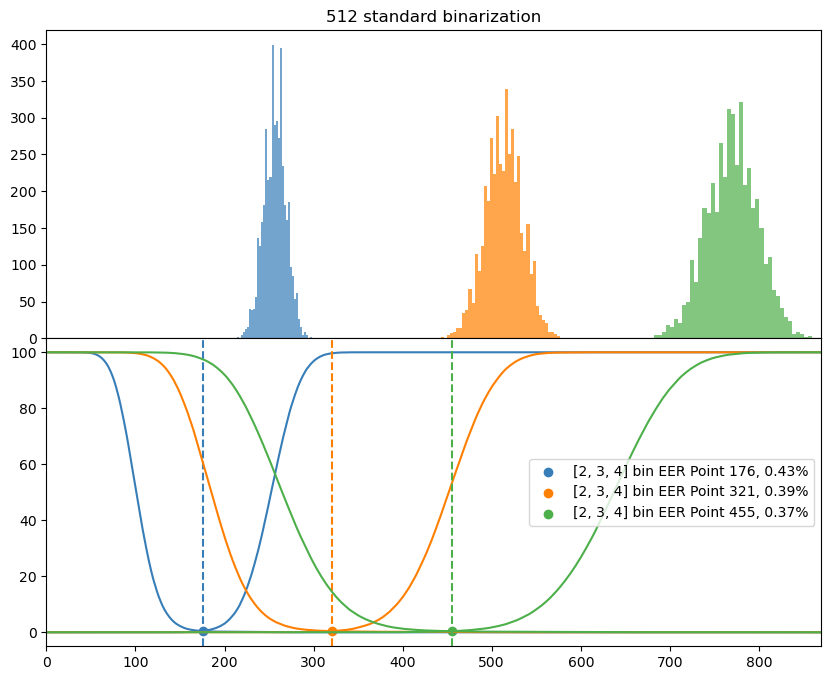

In [ ]:
# Initialize plot
fig = plt.figure(figsize=(10, 8))
gs = fig.add_gridspec(2, hspace=0)
axs = gs.subplots(sharex=True, sharey=False)

# Number of bins to binarize data. The equal probability intevals are latter calculated
bits_list = [2, 3, 4]
for i, bits in enumerate(bits_list):
    # Load embeddings and binarize data
    thresholds = [norm.ppf(1-1/(bits)*i)*np.std(embeddings_512)+np.mean(embeddings_512) for i in range(1, bits)]
    data_b = binarize(data_f512, thresholds, "standard") # Takes 4 secs approx
    # Generate pair of geunine and impostor embeddings
    genuines, imposters = gen_pairs(data_b)
    dist_g = cal_distances(genuines)
    dist_i = cal_distances(imposters)


    bin_length = next(iter(data_b.values())).shape[1]
    thresholds = list(range(0, bin_length + 1))
    fars, frrs = evaluate_threshold(dist_g, dist_i, thresholds)
    eer_th, eer_val = find_eer(thresholds, fars, frrs)

    weights = [int(arr[0].sum()) for arr in data_b.values()]

    # Hamming weight histograms
    mu = np.mean(weights)
    sigma = np.std(weights)
    axs[0].hist(weights, bins=np.linspace(min(weights), max(weights), int(len(weights)/100)), alpha=0.7, color=CB_color_cycle[i])
    
    # FAR and FRR curves
    axs[1].plot(thresholds, fars, color=CB_color_cycle[i])
    axs[1].plot(thresholds, frrs, color=CB_color_cycle[i])
    axs[1].axvline(eer_th, color=CB_color_cycle[i], linestyle='--')
    axs[1].scatter([eer_th], [eer_val], color=CB_color_cycle[i], label=f'{bits} bin EER Point '+f"{eer_th}, {eer_val:.2f}%")

    axs[1].set_xlim(0, max(weights)+10)
axs[1].legend()
axs[0].set_title("512 standard binarization")
plt.show()

Running binary binarization
People selected for genuine pairs: 1272


Generating impostor pairs: 100%|██████████| 100000/100000 [00:00<00:00, 134697.64it/s]


Running binary binarization
People selected for genuine pairs: 1272


Generating impostor pairs: 100%|██████████| 100000/100000 [00:00<00:00, 155654.98it/s]


Running binary binarization
People selected for genuine pairs: 1272


Generating impostor pairs: 100%|██████████| 100000/100000 [00:00<00:00, 137987.23it/s]


Running binary binarization
People selected for genuine pairs: 1272


Generating impostor pairs: 100%|██████████| 100000/100000 [00:00<00:00, 150853.68it/s]


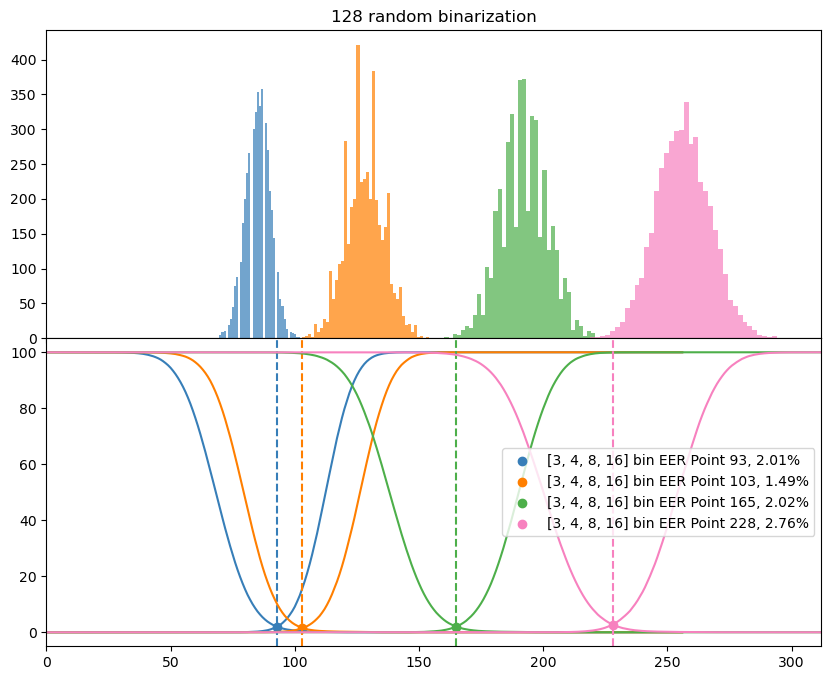

In [14]:
# Initialize plot
fig = plt.figure(figsize=(10, 8))
gs = fig.add_gridspec(2, hspace=0)
axs = gs.subplots(sharex=True, sharey=False)

# Number of bins to binarize data. The equal probability intevals are latter calculated
bits_list = [3, 4, 8, 16]
for i, bits in enumerate(bits_list):
    # Load embeddings and binarize data
    thresholds = [norm.ppf(1-1/(bits)*i)*np.std(embeddings_128)+np.mean(embeddings_128) for i in range(1, bits)]
    data_b = binarize(data_f128, thresholds, "binary") # Takes 4 secs approx
    # Generate pair of geunine and impostor embeddings
    genuines, imposters = gen_pairs(data_b)
    dist_g = cal_distances(genuines)
    dist_i = cal_distances(imposters)


    bin_length = next(iter(data_b.values())).shape[1]
    thresholds = list(range(0, bin_length + 1))
    fars, frrs = evaluate_threshold(dist_g, dist_i, thresholds)
    eer_th, eer_val = find_eer(thresholds, fars, frrs)

    weights = [int(arr[0].sum()) for arr in data_b.values()]

    # Hamming weight histograms
    mu = np.mean(weights)
    sigma = np.std(weights)
    axs[0].hist(weights, bins=np.linspace(min(weights), max(weights), int(len(weights)/100)), alpha=0.7, color=CB_color_cycle[i])
    
    # FAR and FRR curves
    axs[1].plot(thresholds, fars, color=CB_color_cycle[i])
    axs[1].plot(thresholds, frrs, color=CB_color_cycle[i])
    axs[1].axvline(eer_th, color=CB_color_cycle[i], linestyle='--')
    axs[1].scatter([eer_th], [eer_val], color=CB_color_cycle[i], label=f'{bits_list} bin EER Point '+f"{eer_th}, {eer_val:.2f}%")

    axs[1].set_xlim(0, max(weights)+10)
axs[1].legend()
axs[0].set_title("128 random binarization")
plt.show()


People selected for genuine pairs: 1272


Generating impostor pairs: 100%|██████████| 100000/100000 [00:00<00:00, 160058.19it/s]


People selected for genuine pairs: 1272


Generating impostor pairs: 100%|██████████| 100000/100000 [00:00<00:00, 160212.20it/s]


People selected for genuine pairs: 1272


Generating impostor pairs: 100%|██████████| 100000/100000 [00:00<00:00, 150161.68it/s]


People selected for genuine pairs: 1272


Generating impostor pairs: 100%|██████████| 100000/100000 [00:00<00:00, 170168.61it/s]


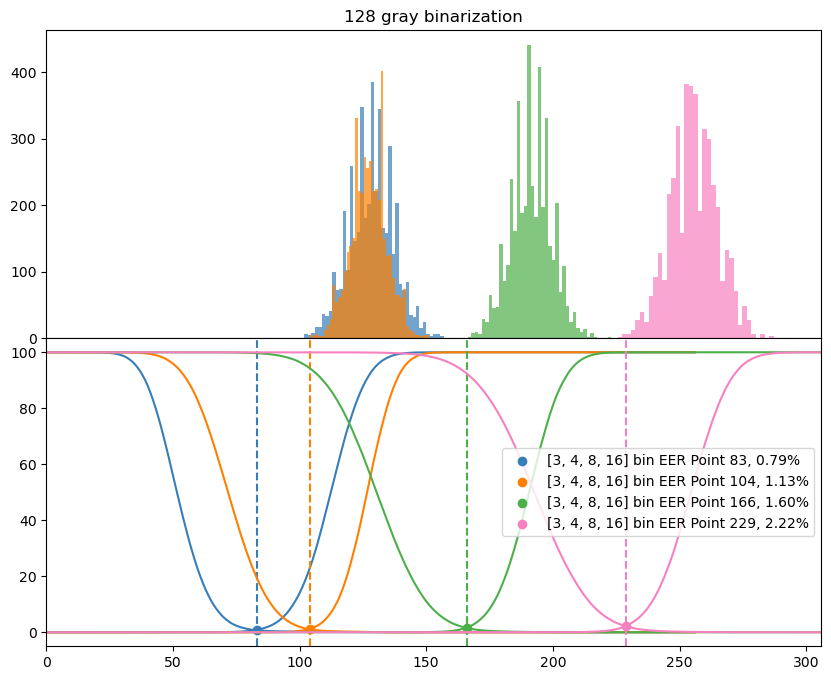

In [ ]:
# Initialize plot
fig = plt.figure(figsize=(10, 8))
gs = fig.add_gridspec(2, hspace=0)
axs = gs.subplots(sharex=True, sharey=False)

# Number of bins to binarize data. The equal probability intevals are latter calculated
bits_list = [3, 4, 8, 16]
for i, bits in enumerate(bits_list):
    # Load embeddings and binarize data
    thresholds = [norm.ppf(1-1/(bits)*i)*np.std(embeddings_128)+np.mean(embeddings_128) for i in range(1, bits)]
    data_b = binarize(data_f128, thresholds, "gray") # Takes 4 secs approx
    # Generate pair of geunine and impostor embeddings
    genuines, imposters = gen_pairs(data_b)
    dist_g = cal_distances(genuines)
    dist_i = cal_distances(imposters)


    bin_length = next(iter(data_b.values())).shape[1]
    thresholds = list(range(0, bin_length + 1))
    fars, frrs = evaluate_threshold(dist_g, dist_i, thresholds)
    eer_th, eer_val = find_eer(thresholds, fars, frrs)

    weights = [int(arr[0].sum()) for arr in data_b.values()]

    # Hamming weight histograms
    mu = np.mean(weights)
    sigma = np.std(weights)
    axs[0].hist(weights, bins=np.linspace(min(weights), max(weights), int(len(weights)/100)), alpha=0.7, color=CB_color_cycle[i])
    
    # FAR and FRR curves
    axs[1].plot(thresholds, fars, color=CB_color_cycle[i])
    axs[1].plot(thresholds, frrs, color=CB_color_cycle[i])
    axs[1].axvline(eer_th, color=CB_color_cycle[i], linestyle='--')
    axs[1].scatter([eer_th], [eer_val], color=CB_color_cycle[i], label=f'{bits} bin EER Point '+f"{eer_th}, {eer_val:.2f}%")

    axs[1].set_xlim(0, max(weights)+10)
axs[1].legend()
axs[0].set_title("128 gray binarization")
plt.show()


People selected for genuine pairs: 1272


Generating impostor pairs: 100%|██████████| 100000/100000 [00:00<00:00, 136966.03it/s]


People selected for genuine pairs: 1272


Generating impostor pairs: 100%|██████████| 100000/100000 [00:00<00:00, 144494.55it/s]


People selected for genuine pairs: 1272


Generating impostor pairs: 100%|██████████| 100000/100000 [00:00<00:00, 161150.73it/s]


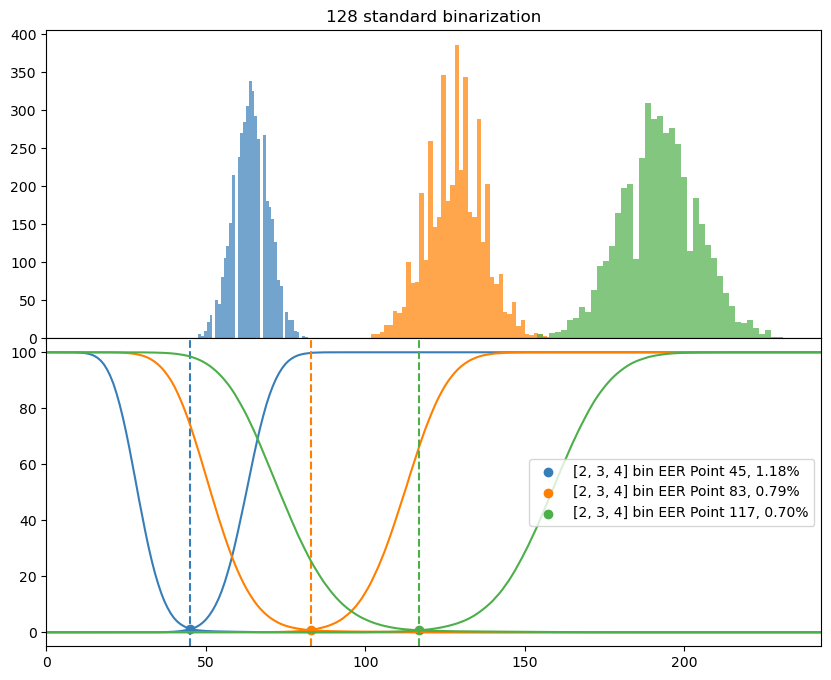

In [16]:
# Initialize plot
fig = plt.figure(figsize=(10, 8))
gs = fig.add_gridspec(2, hspace=0)
axs = gs.subplots(sharex=True, sharey=False)

# Number of bins to binarize data. The equal probability intevals are latter calculated
bits_list = [2, 3, 4]
for i, bits in enumerate(bits_list):
    # Load embeddings and binarize data
    thresholds = [norm.ppf(1-1/(bits)*i)*np.std(embeddings_128)+np.mean(embeddings_128) for i in range(1, bits)]
    data_b = binarize(data_f128, thresholds, "standard") # Takes 4 secs approx
    # Generate pair of geunine and impostor embeddings
    genuines, imposters = gen_pairs(data_b)
    dist_g = cal_distances(genuines)
    dist_i = cal_distances(imposters)


    bin_length = next(iter(data_b.values())).shape[1]
    thresholds = list(range(0, bin_length + 1))
    fars, frrs = evaluate_threshold(dist_g, dist_i, thresholds)
    eer_th, eer_val = find_eer(thresholds, fars, frrs)

    weights = [int(arr[0].sum()) for arr in data_b.values()]

    # Hamming weight histograms
    mu = np.mean(weights)
    sigma = np.std(weights)
    axs[0].hist(weights, bins=np.linspace(min(weights), max(weights), int(len(weights)/100)), alpha=0.7, color=CB_color_cycle[i])
    
    # FAR and FRR curves
    axs[1].plot(thresholds, fars, color=CB_color_cycle[i])
    axs[1].plot(thresholds, frrs, color=CB_color_cycle[i])
    axs[1].axvline(eer_th, color=CB_color_cycle[i], linestyle='--')
    axs[1].scatter([eer_th], [eer_val], color=CB_color_cycle[i], label=f'{bits_list} bin EER Point '+f"{eer_th}, {eer_val:.2f}%")

    axs[1].set_xlim(0, max(weights)+10)
axs[1].legend()
axs[0].set_title("128 standard binarization")
plt.show()


Notice that with 3 bins we only use 00, 01, 10. Hence 1 has smaller provability and smaller hamming weight. 

## Deeper Statistical analysis
Till now we are assuming every every float in the embeddings have the same statistical properties (they follow the same normal distribution). In this section we will analyse a bit more in depth these assuptions.

In [9]:
import random
from scipy.stats import chi2

# Get single random embeddings from each person in data_f128
lista_128 = []
for person in data_f128.keys():
    lista_128.append(data_f128[person][random.randint(0, data_f128[person].shape[0] - 1)])
lista_128 = np.array(lista_128)


<>:37: SyntaxWarning: invalid escape sequence '\m'
<>:41: SyntaxWarning: invalid escape sequence '\s'
<>:37: SyntaxWarning: invalid escape sequence '\m'
<>:41: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_14031/2705322543.py:37: SyntaxWarning: invalid escape sequence '\m'
  plt.title("$\mu$ distrution of each embedding float")
/tmp/ipykernel_14031/2705322543.py:41: SyntaxWarning: invalid escape sequence '\s'
  plt.title("$\sigma$ distrution of each embedding float")


0.113862833502378 1.0


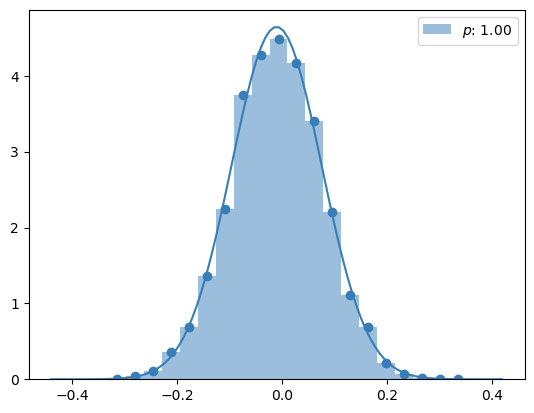

(array([], dtype=int64),)


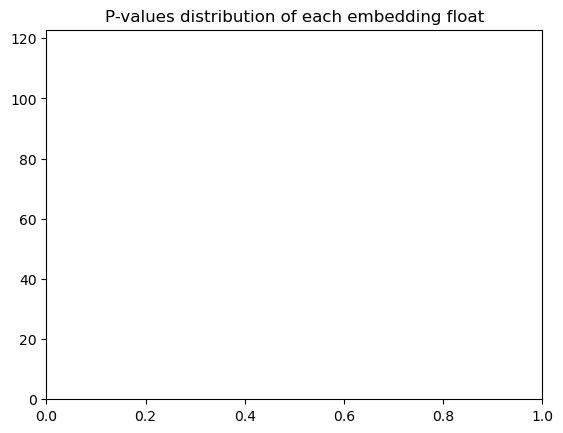

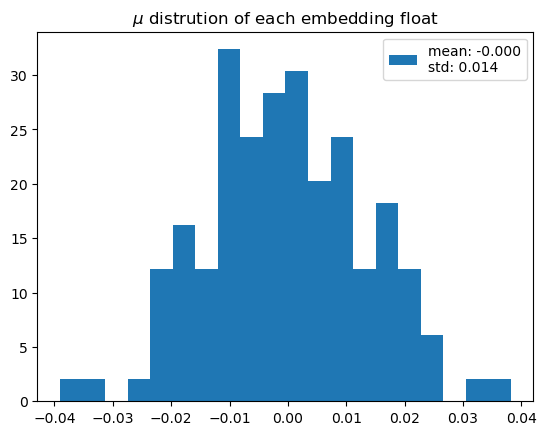

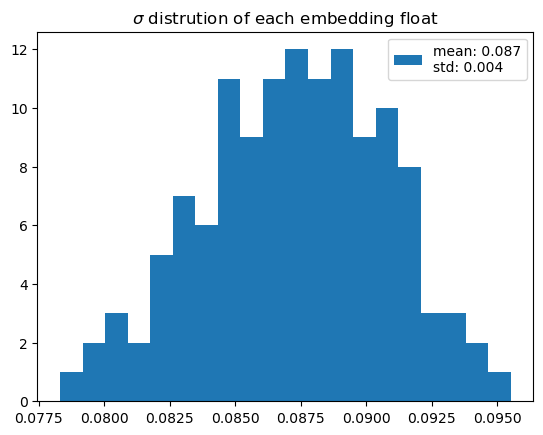

In [ ]:

df = 20 - 1

p_values_list = []
mean_float = []
std_float = []
for i in range(model):
    sigma = np.std(lista_128[:,i])
    mu = np.mean(lista_128[:,i])
    #Plot the Gaussian fit
    x = np.linspace(mu - 5*sigma, mu + 5*sigma, 100)
    y = gauss(x, mu, sigma)
    #Calculate goodness of fit using Chi-squared test
    y_hist, x_hist = np.histogram(lista_128[:,i], bins=(df+1), density=True)
    x_hist = (x_hist[:-1] + x_hist[1:]) / 2  # Get bin centers
    chi2_value = np.sum(((y_hist - gauss(x_hist, mu, sigma)) ** 2) / gauss(x_hist, mu, sigma))
    p_value = 1 - chi2.cdf(chi2_value, df)
    p_values_list.append(p_value)
    mean_float.append(mu)
    std_float.append(sigma)

    if(i == 108):
        print(chi2_value, p_value)
        plt.plot(x, y, color=CB_color_cycle[i%len(CB_color_cycle)])
        plt.scatter(x_hist, y_hist, color=CB_color_cycle[i % len(CB_color_cycle)])
        plt.hist(lista_128[:,i], alpha = 0.5, bins = df + 1, label =f"$p$: {p_value:.2f}",color=CB_color_cycle[i % len(CB_color_cycle)], density=True)

plt.legend()
plt.show()

if any(np.array(p_values_list) < 0.05):
    plt.hist(p_values_list, bins = 20)
    plt.xlim(0, 1)
    plt.title("P-values distribution of each embedding float")
    print(np.where(np.array(p_values_list) < 0.05))
    plt.show()
else:
    print("All p-values are above 0.05, indicating a good fit for all floats.")
    
plt.hist(mean_float, bins = 20, label =f"mean: {np.mean(mean_float):.3f}\nstd: {np.std(mean_float):.3f}", density=True)
plt.title("$\mu$ distrution of each embedding float")
plt.legend()
plt.show()
plt.hist(std_float, bins = 20, label =f"mean: {np.mean(std_float):.3f}\nstd: {np.std(std_float):.3f}")
plt.title("$\sigma$ distrution of each embedding float")
plt.legend()
plt.show()

Deviation from equipobable. We are assuming mean is the mean of every float and the same for std. We will se how far this is for every bit.

In [ ]:
bits = 3
std_values = np.linspace(0.044-0.005, 0.044+0.005, 50)
mean_values = np.linspace(-0.007, 0.007, 50)
difference = np.zeros((50, 50))
std = np.std(lista_128)
mean = np.mean(lista_128)
for i in range(50):
    for j in range(50):
        difference[i, j] = norm.cdf(norm.ppf(1-1/3)*std_values[i] + mean_values[j]) - norm.cdf(norm.ppf(1-1/3)*std +mean)

<>:3: SyntaxWarning: invalid escape sequence '\D'
<>:4: SyntaxWarning: invalid escape sequence '\D'
<>:3: SyntaxWarning: invalid escape sequence '\D'
<>:4: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_6471/907010043.py:3: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel("$\Delta$ Mean")
/tmp/ipykernel_6471/907010043.py:4: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel("$\Delta$ Std")


Text(0, 0.5, '$\\Delta$ Std')

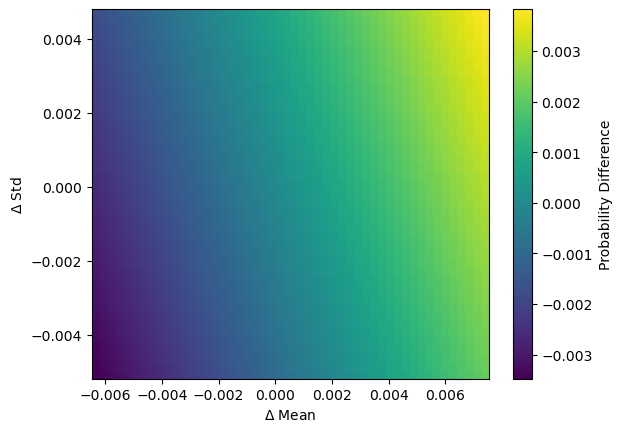

In [77]:
plt.imshow(difference, extent=(mean_values[0]-mean, mean_values[-1]-mean, std_values[0]-std, std_values[-1]-std), origin='lower', aspect='auto', cmap='viridis')
plt.colorbar(label='Probability Difference')
plt.xlabel("$\Delta$ Mean")
plt.ylabel("$\Delta$ Std")

this shows how, as we increase the estimated mean, how the probability of the last "equiprobable" region increses.

### Entropy of the biometry

In [3]:
from sklearn.neighbors import NearestNeighbors
from scipy.special import digamma
import numpy as np
from scipy.special import gamma

def entropy_knn(X, k=3):
    n, d = X.shape
    nbrs = NearestNeighbors(n_neighbors=k + 1).fit(X)
    distances, _ = nbrs.kneighbors(X)
    r = distances[:, -1]  # distance to k-th neighbor

    volume_unit_ball = (np.pi ** (d / 2)) / gamma(d / 2 + 1)
    return (
        digamma(n)
        - digamma(k)
        + d * np.mean(np.log(r + 1e-10))
        + np.log(volume_unit_ball)
    )

In [ ]:
corr = np.corrcoef(lista_128)
cov = np.cov(lista_128)


In [13]:
np.linalg.det(cov)

np.float64(0.0)

In [12]:
entropy_knn(lista_128)

np.float64(-128.3102799872082)

In [17]:
df = 20 - 1
centered_128 = lista_128 
cov = np.cov(centered_128, rowvar=False)

h = np.zeros(128)   
for i in range(128):
    #Calculate goodness of fit using Chi-squared test
    y_hist, x_hist = np.histogram(lista_128[:,i], bins=(df+1), density=True)
    # sum p_i * log(p_i)
    h[i] = -np.sum( (y_hist*(x_hist[1]-x_hist[0])*np.log2(y_hist*(x_hist[1]-x_hist[0])))[y_hist>0])



/tmp/ipykernel_28180/4149014387.py:10: RuntimeWarning: divide by zero encountered in log2
  h[i] = -np.sum( (y_hist*(x_hist[1]-x_hist[0])*np.log2(y_hist*(x_hist[1]-x_hist[0])))[y_hist>0])
/tmp/ipykernel_28180/4149014387.py:10: RuntimeWarning: invalid value encountered in multiply
  h[i] = -np.sum( (y_hist*(x_hist[1]-x_hist[0])*np.log2(y_hist*(x_hist[1]-x_hist[0])))[y_hist>0])


In [23]:
np.sum(h)

np.float64(457.9118175830672)

In [30]:
import numpy as np
from sklearn.decomposition import PCA

def gaussian_entropy_pca(X, eps=1e-10):
    """
    Compute entropy in the reduced intrinsic space where covariance is non-singular.
    """
    n_samples, d = X.shape
    X_centered = X - np.mean(X, axis=0)

    # PCA to find intrinsic dimensionality
    pca = PCA()
    X_pca = pca.fit_transform(X_centered)
    eigvals = pca.explained_variance_

    # Filter out near-zero variance components
    valid = eigvals > eps
    eigvals_reduced = eigvals[valid]
    d_eff = len(eigvals_reduced)

    if d_eff == 0:
        raise ValueError("No dimensions with significant variance.")

    # Joint entropy in intrinsic subspace
    joint_entropy = 0.5 * np.log((2 * np.pi * np.e) ** d_eff * np.prod(eigvals_reduced))

    return {
        'joint_entropy': joint_entropy,
        'effective_dimensions': d_eff,
        'explained_variance': eigvals_reduced
    }

In [32]:
results = gaussian_entropy_pca(lista_128)
print(f"Joint entropy (in {results['effective_dimensions']}D): {results['joint_entropy']:.4f}")


Joint entropy (in 128D): nan


/tmp/ipykernel_28180/3354769792.py:25: RuntimeWarning: overflow encountered in cast
  joint_entropy = 0.5 * np.log((2 * np.pi * np.e) ** d_eff * np.prod(eigvals_reduced))
/tmp/ipykernel_28180/3354769792.py:25: RuntimeWarning: invalid value encountered in scalar multiply
  joint_entropy = 0.5 * np.log((2 * np.pi * np.e) ** d_eff * np.prod(eigvals_reduced))


They are mostly uncorrelated. Since we have seen that all the coefficients follow a Gaussian distribution,w e can use the mutivariate gaussian to calculate the entropy $$H(x) = \frac{1}{2} \log ((2\pi e)^n \det( \Sigma))$$ where $\Sigma$ is the covariance matrix. 

In [43]:
lista_128.shape[1] 

128

In [53]:
print("The bimetry entropy")
print(np.linalg.det(cov))
print(1/2 * (np.log2((2 * np.pi *np.e)**lista_128.shape[1]) + np.log2(np.linalg.det(cov *150) )- np.log2(150.**(1*128))))

The bimetry entropy
0.0
-659.5031231879575


In [ ]:
eigenvals = np.linalg.eigvalsh(cov)
min(eigenvals)
det_e4 = np.prod(eigenvals*1e4) #10**(-4*128)
log2_dete4 = -43*np.log2(10)+np.log2(det_e4*1e43) # -43*log2(10)+log(1.52) #+log 10**(-4*128) =  -4*128*log2(10)
log2_det = log2_dete4 -4*128*np.log2(10) # -4*128*log2(10) = -512*log2(10)
print(log2_det)

-1843.062716182786


In [64]:
det_e4

np.float64(1.5234862504728521e-43)